In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.mongoexp import MongoTrials
from types import SimpleNamespace

import os
from datetime import datetime
import sys
import time
try:
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold  # trainML
except:
    sys.path.append("../input/iterative-stratification")  # kaggle
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
BASE_PATH = os.environ.get('TRAINML_DATA_PATH') if os.environ.get('TRAINML_DATA_PATH') else '../input/lish-moa'
BASE_PATH

'/opt/trainml/input'

In [3]:
train_features = pd.read_csv(f'{BASE_PATH}/train_features.csv')
train_targets = pd.read_csv(f'{BASE_PATH}/train_targets_scored.csv')
test_features = pd.read_csv(f'{BASE_PATH}/test_features.csv')

sample_submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

### Data preprocessing

In [4]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    del df['sig_id']
    return df

train_data = preprocess(train_features)
test_data = preprocess(test_features)

del train_targets['sig_id']

train_targets = train_targets.loc[train_data['cp_type']==0].reset_index(drop=True)
train_data = train_data.loc[train_data['cp_type']==0].reset_index(drop=True)

In [5]:
X_original = train_data.values
Y_original = train_targets.values

X_test = test_data.values

### Data augmentation helper functions

Currently only doing data oversampling with MLSMOTE algorithm.

In [6]:
def get_tail_labels(df: pd.DataFrame, ql=[0.03, 1.]) -> list:
    " Find the underepresented targets a.k.a. minority labels. "
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_labels = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_labels

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.03, 1.]):
    " Find minority samples associated with minority labels. "
    tail_labels = get_tail_labels(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    " Find nearest neighbors for each sample in X dataframe. "
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_samples, n_neighbors=5):
    " Generate new samples using MLSMOTE algorithm. "
    indices2 = nearest_neighbour(X, neigh=n_neighbors)
    n = len(indices2)
    new_X = np.zeros((n_samples, X.shape[1]))
    target = np.zeros((n_samples, y.shape[1]))
    for i in range(n_samples):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

def augment_data(X, y, oversample_args: tuple):
    " Augment feature/targets data (just doing oversampling for now)"
    n_samples, n_neighbors = oversample_args

    X_sub, y_sub = get_minority_samples(X, y)
    X_res, y_res = MLSMOTE(X_sub, y_sub, n_samples, n_neighbors)
    X_augmented = pd.concat([X, X_res])
    y_augmented = pd.concat([y, y_res])
    return X_augmented, y_augmented

### Define model, dataset, gradient descent

In [7]:
class MoaModel(nn.Module):
    def __init__(    
        self,
        n_columns,
        n_targets,
        layer1_outputs,
        layer1_dropout,
        layer2_outputs,
        layer2_dropout,
        layer3_enable,
        layer3_outputs,
        layer3_dropout,
        final_layer_dropout,
    ):
        super(MoaModel, self).__init__()   
        self.batch_norm1 = nn.BatchNorm1d(n_columns)
        self.dropout1 = nn.Dropout(layer1_dropout)
        self.dense1 = nn.utils.weight_norm(nn.Linear(n_columns, layer1_outputs))
        
        self.batch_norm2 = nn.BatchNorm1d(layer1_outputs)
        self.dropout2 = nn.Dropout(layer2_dropout)
        self.dense2 = nn.utils.weight_norm(nn.Linear(layer1_outputs, layer2_outputs))
        
        self.layer3 = layer3_enable
        if self.layer3:
            self.batch_norm3 = nn.BatchNorm1d(layer2_outputs)
            self.dropout3 = nn.Dropout(layer3_dropout)
            self.dense3 = nn.utils.weight_norm(
                nn.Linear(layer2_outputs, layer3_outputs)
            )
            
        final_layer_inputs = layer3_outputs if self.layer3 else layer2_outputs
        self.batch_norm_final = nn.BatchNorm1d(final_layer_inputs)
        self.dropout_final = nn.Dropout(final_layer_dropout)
        self.dense_final = nn.utils.weight_norm(nn.Linear(final_layer_inputs, n_targets))
        
    def forward(self, X):
        X = self.batch_norm1(X)
        X = self.dropout1(X)
        X = F.relu(self.dense1(X))
        
        X = self.batch_norm2(X)
        X = self.dropout2(X)
        X = F.relu(self.dense2(X))
        
        if self.layer3:
            X = self.batch_norm3(X)
            X = self.dropout3(X)
            X = F.relu(self.dense3(X))
            
        X = self.batch_norm_final(X)
        X = self.dropout_final(X)
        X = F.sigmoid(self.dense_final(X))
        
        return X
    
    def _load_from_file(self, file):
        self.load_state_dict(torch.load(file))
        
    def save(self, file):
        torch.save(self.state_dict(), file)
        
def batch_gd(model, device, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    for it in range(epochs):
        t0 = datetime.now()

        model.train()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item() / len(train_loader))

        train_loss = np.mean(train_loss)

        model.eval()
        val_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item() / len(val_loader))
        val_loss = np.mean(val_loss)

        train_losses[it] = train_loss
        val_losses[it] = val_loss

        dt = datetime.now() - t0
#         print(
#             f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration {dt}"
#         )

    return train_losses, val_losses

In [8]:
class MoaDataset(Dataset):
    def __init__(self, features, targets, mode="train"):
        self.mode = mode
        self.data = features
        if mode == "train":
            self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mode == "train":
            return torch.FloatTensor(self.data[idx]), torch.FloatTensor(
                self.targets[idx]
            )
        elif self.mode == "eval":
            return torch.FloatTensor(self.data[idx]), 0

### Helper functions for hyperopt's `objective`

In [9]:
def augment_data(X, y, n_samples, n_neighbors):
    """
    Augment feature/targets data with oversampling (using MLSMOTE algorithm)
    """
    X_sub, y_sub = get_minority_samples(X, y)
    X_res, y_res = MLSMOTE(X_sub, y_sub, n_samples, n_neighbors)
    X_augmented = pd.concat([X, X_res])
    y_augmented = pd.concat([y, y_res])
    return X_augmented, y_augmented


def make_model(
        n_columns,
        n_targets,
        layer1_outputs,
        layer1_dropout,
        layer2_outputs,
        layer2_dropout,
        layer3_enable,
        layer3_outputs,
        layer3_dropout,
        final_layer_dropout,
        device
    ):
    """
    Make a 2 or 3 layer neural network with specified outputs and dropout per layer.
    """
    model = MoaModel(n_columns, n_targets, layer1_outputs, layer1_dropout, layer2_outputs,
                   layer2_dropout, layer3_enable, layer3_outputs, layer3_dropout, final_layer_dropout)
    model.to(device)
    return model


def train(model, device, optimizer, X, Y, n_splits, batch_size, epochs):
    """
    Run model training with a stratified k-fold cross validation split according to specified
    parameters. Returns tuple (train_losses, val_losses).
    """
    kfold = MultilabelStratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

    criterion = nn.BCELoss()

    train_losses = np.array([])
    val_losses = np.array([])

    for n, (tr, te) in enumerate(kfold.split(X, Y)):
        X_train, X_val = X[tr], X[te]
        y_train, y_val = Y[tr], Y[te]

        train_dataset = MoaDataset(X_train, y_train)
        val_dataset = MoaDataset(X_val, y_val)
        train_loader = torch.utils.data.DataLoader(
            dataset=train_dataset, batch_size=batch_size, shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            dataset=val_dataset, batch_size=batch_size, shuffle=False
        )
        split_train_losses, split_val_losses = batch_gd(
            model, device, criterion, optimizer, train_loader, val_loader, epochs
        )
#         print(
#             f"Fold {n+1}, final train loss: {split_train_losses[epochs-1]:5.5f}, final train loss: {split_val_losses[epochs-1]:5.5f}"
#         )
        train_losses = np.concatenate((train_losses, split_train_losses))
        val_losses = np.concatenate((val_losses, split_val_losses))

    model.save("latest_model")
    return train_losses, val_losses


def predict(model, device, data_loader):
    """
    Generate label predictions given trained model and feature data.
    """
    model.eval()
    preds = []

    for inputs, _ in data_loader:
        inputs = inputs.to(device)

        with torch.no_grad():
            outputs = model(inputs)

        preds.append(outputs.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def calculate_loss(model, device, X_eval, Y_eval, batch_size):
    """
    Feed original data set into trained model and generate log-loss score.
    """
    eval_dataset = MoaDataset(X_eval, None, mode='eval')
    eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False)
    preds = predict(model, device, eval_loader)
    
    loss_fn = nn.BCELoss()
    Y_pred = torch.from_numpy(preds.astype(float))
    Y_true = torch.from_numpy(Y_eval.astype(float))
    loss = loss_fn(Y_pred, Y_true)
    return loss.item()

### Hyperopt config - objective function and search space

In [10]:
def objective(space):
    args = SimpleNamespace(**space)
    
    # Augment data
    X_original = args.train_data.values
    Y_original = args.train_targets.values
    train_data, train_targets = augment_data(args.train_data, args.train_targets, args.n_samples, args.n_neighbors)
    X = train_data.values
    Y = train_targets.values
    
    # Build model architecture
    device = args.device
    torch.cuda.empty_cache()
    model = make_model(
                args.n_columns,
                args.n_targets,
                args.layer1_outputs,
                args.layer1_dropout,
                args.layer2_outputs,
                args.layer2_dropout,
                args.layer3_enable,
                args.layer3_outputs,
                args.layer3_dropout,
                args.final_layer_dropout,
                device
    )
    
    # Train model
    optimizer = None
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters())
    elif args.optimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters())
    elif args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    elif args.optimizer == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters())
    train_losses, val_losses = train(model, device, optimizer, X, Y, args.n_splits, args.batch_size, args.epochs)
    
    # Calculate loss
    loss = calculate_loss(model, device, X_original, Y_original, args.batch_size)

    return {
        'loss': loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'model_result': model,
        'status': STATUS_OK,
        'eval_time': time.time()
    }
    

space = {
    # general
    'device': torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
    'train_data': train_data,
    'train_targets': train_targets,
    
    # data augmentation
    'n_samples': hp.randint('n_samples', 5000),
    'n_neighbors': 3 + hp.randint('n_neighbors', 10),
    
    # model architecture
    'n_columns': train_data.shape[1],
    'n_targets': train_targets.shape[1],
    'layer1_outputs': 256 + hp.randint('layer1_outputs', 4096),
    'layer1_dropout': hp.uniform('layer1_dropout', 0, 1),
    'layer2_outputs': 256 + hp.randint('layer2_outputs', 4096),
    'layer2_dropout': hp.uniform('layer2_dropout', 0, 1),
    'layer3_enable': hp.choice('layer3_enable', [True, False]),
    'layer3_outputs': 256 + hp.randint('layer3_outputs', 4096),
    'layer3_dropout': hp.uniform('layer3_dropout', 0, 1),
    'final_layer_dropout': hp.uniform('final_layer_dropout', 0, 1),
    
    # cross-validation
    'optimizer': hp.choice('optimizer', ['adam', 'adagrad', 'sgd', 'rmsprop']),
    'n_splits': 5 + hp.randint('n_splits', 10),
    'batch_size': 64 + hp.randint('batch_size', 4096),
    'epochs': 10 + hp.randint('epochs', 90)
}

### Run model training via hyperopt

In [11]:
trials = Trials() # TODO: Make it MongoTrials
best = fmin(
    objective,
    space=space,
    algo=tpe.suggest,
    max_evals=75,
    trials=trials
    # max_queue_len=4 <-- what again is this used for? multiple workers?
)
print(best)

  0%|          | 0/75 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  1%|▏         | 1/75 [06:34<8:06:49, 394.73s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  3%|▎         | 2/75 [16:53<9:21:59, 461.92s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  4%|▍         | 3/75 [18:40<7:06:39, 355.54s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  5%|▌         | 4/75 [26:18<7:36:51, 386.08s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  7%|▋         | 5/75 [37:13<9:04:37, 466.82s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  8%|▊         | 6/75 [47:55<9:57:21, 519.45s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



  9%|▉         | 7/75 [1:08:39<13:55:03, 736.81s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 11%|█         | 8/75 [1:12:08<10:45:51, 578.38s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 12%|█▏        | 9/75 [1:25:26<11:48:47, 644.35s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 13%|█▎        | 10/75 [1:33:26<10:44:27, 594.88s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 15%|█▍        | 11/75 [1:36:18<8:19:30, 468.28s/trial, best loss: 0.0006003098074222969] 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 16%|█▌        | 12/75 [1:38:57<6:34:16, 375.51s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 17%|█▋        | 13/75 [1:43:40<5:59:18, 347.73s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 19%|█▊        | 14/75 [2:08:26<11:40:34, 689.09s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 20%|██        | 15/75 [2:10:36<8:41:22, 521.38s/trial, best loss: 0.0006003098074222969] 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 21%|██▏       | 16/75 [2:18:55<8:26:11, 514.77s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 23%|██▎       | 17/75 [2:29:43<8:56:01, 554.51s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 24%|██▍       | 18/75 [2:48:25<11:28:37, 724.87s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 25%|██▌       | 19/75 [2:54:16<9:31:53, 612.74s/trial, best loss: 0.0006003098074222969] 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 27%|██▋       | 20/75 [3:03:52<9:11:28, 601.60s/trial, best loss: 0.0006003098074222969]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 28%|██▊       | 21/75 [3:16:01<9:35:56, 639.93s/trial, best loss: 0.00030249957568826086]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 29%|██▉       | 22/75 [3:19:12<7:26:21, 505.32s/trial, best loss: 0.00030249957568826086]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 31%|███       | 23/75 [3:25:08<6:39:09, 460.57s/trial, best loss: 0.00030249957568826086]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 32%|███▏      | 24/75 [3:33:09<6:36:41, 466.69s/trial, best loss: 0.00030249957568826086]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 33%|███▎      | 25/75 [3:39:17<6:04:03, 436.87s/trial, best loss: 0.00030249957568826086]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 35%|███▍      | 26/75 [3:53:03<7:32:12, 553.72s/trial, best loss: 0.00030249957568826086]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 36%|███▌      | 27/75 [3:56:21<5:57:37, 447.03s/trial, best loss: 0.00030249957568826086]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 37%|███▋      | 28/75 [4:00:11<4:59:13, 381.99s/trial, best loss: 0.00030249957568826086]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 39%|███▊      | 29/75 [4:12:07<6:09:30, 481.96s/trial, best loss: 0.00030249957568826086]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 40%|████      | 30/75 [4:29:17<8:04:54, 646.54s/trial, best loss: 5.0051690428067324e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 41%|████▏     | 31/75 [4:38:17<7:30:42, 614.60s/trial, best loss: 5.0051690428067324e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 43%|████▎     | 32/75 [4:53:11<8:20:30, 698.38s/trial, best loss: 3.008819506610299e-05] 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 44%|████▍     | 33/75 [5:04:50<8:09:01, 698.61s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 45%|████▌     | 34/75 [5:16:46<8:00:48, 703.63s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 47%|████▋     | 35/75 [5:35:03<9:07:54, 821.85s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 48%|████▊     | 36/75 [5:38:22<6:52:39, 634.85s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 49%|████▉     | 37/75 [5:42:08<5:24:27, 512.29s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 51%|█████     | 38/75 [6:10:12<8:52:45, 863.92s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 52%|█████▏    | 39/75 [6:19:48<7:46:23, 777.32s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 53%|█████▎    | 40/75 [6:22:05<5:41:29, 585.40s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 55%|█████▍    | 41/75 [6:30:42<5:20:01, 564.74s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 56%|█████▌    | 42/75 [6:49:33<6:44:03, 734.66s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 57%|█████▋    | 43/75 [7:00:57<6:23:45, 719.54s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



 59%|█████▊    | 44/75 [7:05:47<5:05:10, 590.66s/trial, best loss: 3.008819506610299e-05]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")

job exception: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 1; 7.80 GiB total capacity; 6.74 GiB already allocated; 14.31 MiB free; 6.95 GiB reserved in total by PyTorch)



 59%|█████▊    | 44/75 [7:06:09<5:00:14, 581.13s/trial, best loss: 3.008819506610299e-05]


RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 1; 7.80 GiB total capacity; 6.74 GiB already allocated; 14.31 MiB free; 6.95 GiB reserved in total by PyTorch)

In [16]:
best

{'batch_size': 865,
 'epochs': 77,
 'final_layer_dropout': 0.28004207729618613,
 'layer1_dropout': 0.0008458399009278472,
 'layer1_outputs': 1016,
 'layer2_dropout': 0.36695591557539453,
 'layer2_outputs': 961,
 'layer3_dropout': 0.6847973767437818,
 'layer3_enable': 1,
 'layer3_outputs': 2776,
 'n_neighbors': 1,
 'n_samples': 4042,
 'n_splits': 7}

In [36]:
trials.results[0].keys()

dict_keys(['loss', 'train_losses', 'val_losses', 'model_result', 'status', 'eval_time'])

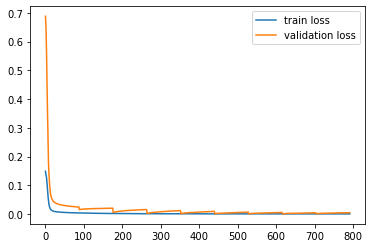

In [43]:
train_losses = trials.results[-1]['train_losses']
val_losses = trials.results[-1]['val_losses']

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

### Generate predictions

In [50]:
final_model = trials.results[-1]['model_result']
batch_size = best['batch_size']
device = space['device']
test_dataset = MoaDataset(X_test, None, mode='eval')
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

preds = predict(final_model, device, test_loader)

In [ ]:
targets = [col for col in train_targets.columns]
sample_submission[targets] = preds
sample_submission.loc[test_features['cp_type']=='ctl_vehicle', targets] = 0
sample_submission.to_csv('submission.csv', index=False)

### Model evaluation

In [ ]:
train_dataset = MoaDataset(X_original, None, mode='eval')
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
mock_preds = predict(model, device, train_loader)

In [ ]:
loss_fn = nn.BCELoss()

y_pred = torch.from_numpy(mock_preds.astype(float))
y_true = torch.from_numpy(Y_original.astype(float))

score = loss_fn(y_pred, y_true)
print("log-loss score: ", score.item())

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# compute ROC AUC curve and AUC score using micro-averaging
fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregate ROC curve (micro-averaging)')
plt.legend(loc="lower right")
plt.show()

print("ROC AUC score: ", roc_auc_score(y_true, y_pred, average='micro'))

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

decision_boundary = 0.5
confusion_matrices = multilabel_confusion_matrix(y_true, (y_pred > decision_boundary))

agg_confusion_matrix = np.array([[0, 0],  # [tn, fp]
                                 [0, 0]])  # [fn, tp]
for m in confusion_matrices:
    agg_confusion_matrix += m

print(agg_confusion_matrix)

### Export model

In [ ]:
# use torch.save() to export model, I think I also have to use pickle?